### Text Pre-processing
This notebook is for text pre-processing of complaint narrative. Prapare it in a way the output can be used for diferent machine learning algorithms 

First step load several helpful packages 

In [1]:
import re
import numpy as np 
import pandas as pd 
from collections import Counter

'''text pre-processing'''
import nltk #to use the stopwords library
import string # for a list of all punctuation
from nltk.corpus import stopwords # for a list of stopwords
from nltk.tokenize import word_tokenize # for tokenization

from nltk.stem import PorterStemmer   # for the purpose of stemming
from nltk.stem import WordNetLemmatizer  # for Lemmatization
from nltk import pos_tag  # for POS tagging

#for wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Hide Warnings
Warning = False
if Warning is False:
    import warnings
    warnings.filterwarnings(action='ignore')
    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    warnings.filterwarnings(action='ignore', category=FutureWarning)



### Data Extraction :  Load the dataset 

In [2]:

complaints=pd.read_csv(r'C:\Shalini\Project-1\extra_dataset_complaint\complaints.csv')

complaints.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

### rename column headings
The column names has (spaces) '?'and Upper case . In order to keep it simple Lets change it to lower case joined with '_'.

In [3]:
# rename column names

complaints.columns = [name.lower() for name in complaints.columns.str.replace(" ", "_")]
complaints.columns = [name.lower() for name in complaints.columns.str.replace("?", "")]
complaints.columns

Index(['date_received', 'product', 'sub-product', 'issue', 'sub-issue',
       'consumer_complaint_narrative', 'company_public_response', 'company',
       'state', 'zip_code', 'tags', 'consumer_consent_provided',
       'submitted_via', 'date_sent_to_company', 'company_response_to_consumer',
       'timely_response', 'consumer_disputed', 'complaint_id'],
      dtype='object')

In [4]:
df_complain_product = complaints[['consumer_complaint_narrative','product','consumer_disputed']]

### Data Transformation
For this project, Mainly the following three columns needed.
narrative, product and  consumer_disputed. Create new dataframe with these columns.
Examine the shape of new dataframe and check for the number of complaints for each product. 
There are 1 048 575 rows are there with 3 needed columns.

In [5]:
df_complain_product.shape

(1048575, 3)

In [6]:
df_complain_product['product'].value_counts()

Mortgage                                                                        224168
Credit reporting, credit repair services, or other personal consumer reports    206387
Debt collection                                                                 189452
Credit reporting                                                                110459
Credit card                                                                      69368
Bank account or service                                                          69234
Credit card or prepaid card                                                      40633
Student loan                                                                     38057
Checking or savings account                                                      33961
Consumer Loan                                                                    23589
Vehicle loan or lease                                                             9122
Money transfer, virtual currency, or money 

### check 2
Looking for the null values. A text cannot be analysed or classified if it is null. Deleting all those row where consumer_complaint_narrative = nan. 762 872 rows does not have textutal narrative data for classification.


In [7]:
df_complain_product.isnull().sum()

consumer_complaint_narrative    762872
product                           6426
consumer_disputed               445277
dtype: int64

In [8]:

df_complain_product = df_complain_product.dropna(axis=0, subset=['consumer_complaint_narrative'])
df_complain_product.shape

(285703, 3)

In [9]:
df_complain_product.iloc[131]['consumer_complaint_narrative']

'There are several accounts reporting on my credit file that does not belong to me. I have sent the credit agencies letters to dispute these accounts. The listed accounts are reporting as a result of identity theft. Please remove the following accounts and incorrect information from my credit file : Incorrect Name : XXXX XXXX ( XXXX ) Incorrect Addresses : XXXX XXXX XXXX XXXX XXXX XXXX, ( Experian & XXXX ) Identity Theft Account : XXXX XXXX XXXX XXXX ( Experian & XXXX  ) Identity Theft Account : XXXX XXXX XXXX  ( Experian & XXXX ) Inquiries : XXXX XXXX XXXX ( 2 Times )XXXX XXXX XXXX XXXX, XXXX XXXX, XXXX XXXX XXXX, XXXX XXXX, XXXX XXXX, XXXX XXXX ( 3 Times ), XXXX, XXXX, XXXX XXXX XXXX XXXX XXXX'

### Text Pre-processing
A function is created for the cleanint of text, it removes punctuation, number,  ascii charecters and xxxx created by annonymiser. It also changes the text to lower case. The output is saved in a new column clean_text in the datafame df_complain_product. 

In [12]:
def clean_text_func(string):
   # clean incoming string for punctuations , numbers, xxx, xxxx 

    string = re.sub(r"[^A-Za-z()!?\'\`]", " ", string)
    string = re.sub(r"[?!;:,#@-]}{", "", string)
    
    string = re.sub(r"\(", "", string)
    string = re.sub(r"\)", "", string)
    
    string = re.sub(r"\??", "", string)
    string = re.sub(r"\'", " ", string)
    
    
    # removing  xxxx and xxxx 
    string = re.sub(r'\S*(x{2,}|X{2,})\S*',"",string)
    string = re.sub(r"\d\.\*\%$","",string)
    
    # removing non ascii
    string = re.sub(r'[^\x00-\x7F]+', "", string) 
    
    return string.strip().lower()


In [13]:
# change the type of variable from object to string

df_complain_product['consumer_complaint_narrative'] = df_complain_product['consumer_complaint_narrative'].astype('str')

In [14]:
df_complain_product['clean_text'] = df_complain_product['consumer_complaint_narrative'].apply(lambda x: clean_text_func(x))

In [15]:
df_complain_product.iloc[131]['clean_text']

'there are several accounts reporting on my credit file that does not belong to me  i have sent the credit agencies letters to dispute these accounts  the listed accounts are reporting as a result of identity theft  please remove the following accounts and incorrect information from my credit file   incorrect name        incorrect addresses           experian     identity theft account        experian      identity theft account        experian     inquiries         times                        times'

In [18]:
df_complain_product.shape

(285703, 5)

### Tokenization 

Tokenization is the process of find meaningful linguistic unit in the given textual data. The clean_text is used as input for the word_tokenize function. And again output is saved in a new column'token_clean_text'.


In [17]:
df_complain_product['token_clean_text']=df_complain_product['clean_text'].apply(lambda x: word_tokenize(x))
df_complain_product['token_clean_text'].head(1)



0    [transworld, systems, inc, is, trying, to, col...
Name: token_clean_text, dtype: object

### Stop word Removal
Stop words are a set of very commonly used words for any language. Mainly they are articles, prepositions, conjunctions and pronouns. In NLP, stop words are eliminated, which allows model to concentrate on other important words instead.     
Locally found not useful words can also be removed by adding it to variable addlocal_stop_words and then to stop word list.
Output is saved in 'clean_token' column of the dataframe df_complain_product.

In [19]:

stopwords_en = stopwords.words('english')
addlocal_stop_words = ['t', 'will','u','c','f','n','may','email' , 'call', 'us']
stopwords_en += addlocal_stop_words


In [20]:
def remove_stopword(text):
    clean_text = list(filter(lambda token: token not in (stopwords_en ) , text))
    return clean_text

In [21]:

df_complain_product['clean_tokens'] = df_complain_product['token_clean_text'].map(lambda d: remove_stopword(d))

df_complain_product['clean_tokens'][20]

['already',
 'tried',
 'contact',
 'company',
 'following',
 'complaint',
 'times',
 'using',
 'different',
 'avenues',
 'recent',
 'sent',
 'requested',
 'contact',
 'least',
 'acknowledge',
 'complaint',
 'received',
 'gotten',
 'responses',
 'since',
 'complaint',
 'first',
 'filed',
 'three',
 'weeks',
 'ago',
 'text',
 'submitted',
 'complaint',
 'follows',
 'concern',
 'writing',
 'submit',
 'formal',
 'complaint',
 'regarding',
 'poor',
 'service',
 'received',
 'working',
 'closing',
 'mark',
 'home',
 'loan',
 'strongly',
 'considering',
 'submitting',
 'formal',
 'complaint',
 'consumer',
 'financial',
 'protection',
 'bureau',
 'similar',
 'state',
 'agency',
 'colorado',
 'california',
 'feel',
 'instances',
 'pushed',
 'boundaries',
 'acceptable',
 'possible',
 'legal',
 'behavior',
 'entire',
 'loan',
 'process',
 'company',
 'start',
 'finish',
 'unprofessional',
 'best',
 'downright',
 'deceptive',
 'potentially',
 'life',
 'impacting',
 'forgotten',
 'lied',
 'put',
 '

### Stemming
stemmimg is the process of reducing word to its root (or stem) by removing suffix. Many variation of word can have same root. This is one of important step in NLP word normalization process. 
Porter stemmet is used for its simplicity and speed.
Output is saved in new columns 'stem_tokens' .

In [22]:


var_portstem = PorterStemmer()

df_complain_product['stem_tokens']=df_complain_product['clean_tokens']

df_complain_product['stem_tokens'] =df_complain_product['stem_tokens'].map(lambda token: [var_portstem.stem(w) for w in token])

In [23]:
df_complain_product['stem_tokens'][20435]

['spoke',
 'account',
 'supervisor',
 'chase',
 'confirm',
 'account',
 'doubl',
 'charg',
 'interest',
 'promot',
 'interest',
 'balanc',
 'monthli',
 'payment',
 'appli',
 'monthli',
 'interest',
 'instead',
 'monthli',
 'interest',
 'ad',
 'princip',
 'amount',
 'princip',
 'increas',
 'monthli',
 'therebi',
 'increas',
 'accru',
 'interest',
 'consequ',
 'chase',
 'charg',
 'interest',
 'interest',
 'everi',
 'month',
 'increas',
 'princip',
 'monthli',
 'payment',
 'cover',
 'interest',
 'minimum',
 'payment',
 'due',
 'inform',
 'although',
 'unfair',
 'chase',
 'per',
 'feder',
 'law',
 'without',
 'state',
 'feder',
 'law',
 'offer',
 'provid',
 'copi',
 'feder',
 'law',
 'refus',
 'elev',
 'matter',
 'supervisor',
 'provid',
 'address',
 'submit',
 'written',
 'complaint',
 'wrong',
 'monthli',
 'payment',
 'cover',
 'minimum',
 'payment',
 'interest',
 'payment',
 'chase',
 'increas',
 'princip',
 'amount',
 'ad',
 'monthli',
 'interest',
 'amount',
 'princip',
 'balanc',
 'i

### POS tagging
It is known as a part-of-speech tagger. It reads a word and assign one of POS tag to it. so it annotate each word in given text with a part of speech marker.
And it does take time. for this dataset it takes near to 30 min to give the output.

In [27]:

df_complain_product['pos_tag_tokens']=df_complain_product['clean_tokens']
df_complain_product['pos_tag_tokens'] = df_complain_product['pos_tag_tokens'].apply(pos_tag)

# Nouns NN , Adjectives  JJ, adverbs RB , verb VB,NNS nousplural

stay_pos_tags = ['JJ', 'NN', 'VB', 'NNS','RB']
df_complain_product['pos_tag_tokens']  = 
df_complain_product['pos_tag_tokens'].apply(lambda token: [pt[0] for pt in token if pt[1] in stay_pos_tags])


In [28]:
df_complain_product['pos_tag_tokens'].head(2)

0    [transworld, systems, collect, debt, mine, ina...
2    [like, suppression, items, credit, report, res...
Name: pos_tag_tokens, dtype: object

### Lematization
Lemmatization is reducing word to its dictionary form root. It is a form of NLP. There is a difference between stemming and lemmatization. Stemming reduces word to pseudo-stem whereas lemmatization reduceds word to dictionary-form stem.(lemma)
Python NLTK provides WordNetLemmatizer, which is used here, it uses WordNet database to lookup lemma of words.


In [32]:
# Lemmatize
var_lemtzr = WordNetLemmatizer()
#df_complain_product['lemm_tokens']=df_complain_product['clean_tokens']
df_complain_product['lemm_tokens']=df_complain_product['pos_tag_tokens']
df_complain_product['lemm_tokens'] =
df_complain_product['lemm_tokens'].map(lambda token: [var_lemtzr.lemmatize(w ,pos="v") for w in token])


In [33]:

df_complain_product['lemm_tokens'][58020]

['credit',
 'report',
 'personal',
 'information',
 'victim',
 'identity',
 'first',
 'step',
 'check',
 'report',
 'discrepancies',
 'credit',
 'bureaus',
 'change']

### Compare the output
As the output is stored in separate column it can be compared and the best output can be taken for the next step. 
For this project the output after lemmatization along with product and consumer_disputed will be saved for futher steps.

In [31]:
df_complain_product.head(5).T

,0,2,3,7,8
consumer_complaint_narrative,transworld systems inc. \nis trying to collect...,I would like to request the suppression of the...,"Over the past 2 weeks, I have been receiving e...","I was sold access to an event digitally, of wh...",While checking my credit report I noticed thre...
product,Debt collection,"Credit reporting, credit repair services, or o...",Debt collection,"Money transfer, virtual currency, or money ser...",Debt collection
consumer_disputed,NaN,NaN,NaN,NaN,NaN
clean_text,transworld systems inc is trying to collect ...,i would like to request the suppression of the...,over the past weeks i have been receiving e...,i was sold access to an event digitally of wh...,while checking my credit report i noticed thre...
token_clean_text,"[transworld, systems, inc, is, trying, to, col...","[i, would, like, to, request, the, suppression...","[over, the, past, weeks, i, have, been, receiv...","[i, was, sold, access, to, an, event, digitall...","[while, checking, my, credit, report, i, notic..."
clean_tokens,"[transworld, systems, inc, trying, collect, de...","[would, like, request, suppression, following,...","[past, weeks, receiving, excessive, amounts, t...","[sold, access, event, digitally, screenshots, ...","[checking, credit, report, noticed, three, col..."
stem_tokens,"[transworld, system, inc, tri, collect, debt, ...","[would, like, request, suppress, follow, item,...","[past, week, receiv, excess, amount, telephon,...","[sold, access, event, digit, screenshot, detai...","[check, credit, report, notic, three, collect,..."
lemm_tokens,"[transworld, systems, inc, try, collect, debt,...","[would, like, request, suppression, follow, it...","[past, weeks, receive, excessive, amount, tele...","[sell, access, event, digitally, screenshots, ...","[check, credit, report, notice, three, collect..."
pos_tag_tokens,"[transworld, systems, collect, debt, mine, ina...","[like, suppression, items, credit, report, res...","[past, weeks, excessive, amounts, telephone, c...","[access, event, digitally, screenshots, detail...","[credit, report, collections, company, ars, un..."


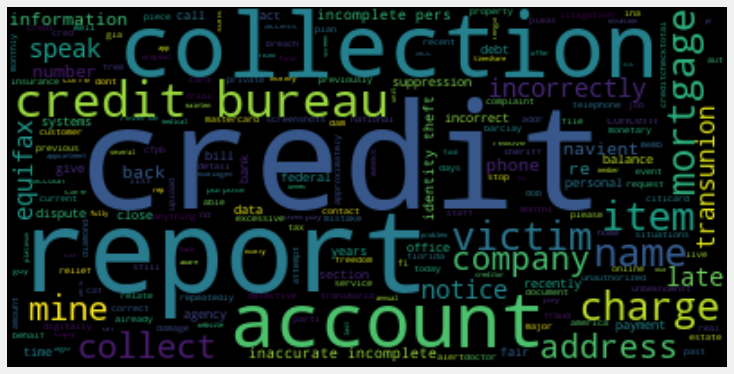

In [13]:
from wordcloud import WordCloud, STOPWORDS

%matplotlib inline

text= df_complain_product['lemm_tokens']

wordcloud = WordCloud().generate(str(text))

fig = plt.figure(
    figsize = (10, 8),
    facecolor = '#F0F0F0',
    edgecolor = '#F0F0F0')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

In [37]:
df_complaints=df_complain_product[['product' ,'consumer_disputed', 'lemm_tokens']]

In [39]:
# Save the procesed complaints for later - for modeling

df_complaints.to_pickle('preprocess_done_complaints.pickle')